In [33]:
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import time
import zlib

In [34]:
#image_name = 'test.JPG'
#image_name = 'test.png'
image_name = 'test.jpg'
img = cv2.imread(image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_arr = np.asarray(img, dtype=np.int16)

# Add edges
arr_1024_a = np.append([img_arr[0, :]], np.append(img_arr, [img_arr[-1, :]], axis = 0), axis = 0)
arr_1024 = np.append(np.transpose([arr_1024_a[:, 0]]),  np.append(arr_1024_a, np.transpose([arr_1024_a[:, -1]]), axis = 1), axis = 1)
img = arr_1024

np.savetxt("input_image_2.txt", img, fmt = "%d", delimiter = "\t")
np.savetxt("image.h", img.reshape((1, img.size)), fmt = "%d", delimiter = ", ")

num_iterations = 100
img.shape

(770, 1026)

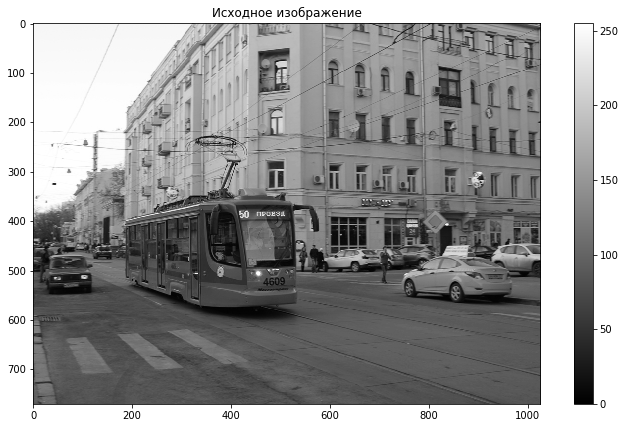

In [35]:
plt.figure(figsize = (12,  7))
plt.title("Исходное изображение")
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.savefig("original.png", dpi = 300)
plt.show()

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html

## OpenCV

Filtering time: 8.34 ms


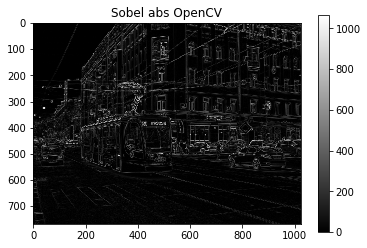

(768, 1024)
Image CRC: 0x33f27cb0


In [41]:
t_start = time.time()
for i in range(num_iterations):
    sobelx_opencv = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3)
    sobely_opencv = cv2.Sobel(img, cv2.CV_16S, 0, 1, ksize=3)
    sobel_opencv = (np.abs(sobelx_opencv) + np.abs(sobely_opencv))[1:-1, 1:-1]
t_end = time.time()

print("Filtering time: " + format((t_end - t_start) * 1000 / num_iterations, ".2f") + " ms")

plt.title("Sobel abs OpenCV")
plt.imshow(sobel_opencv, cmap='gray')
plt.colorbar()
plt.show()

print(sobel_opencv.shape)
print("Image CRC:", hex(zlib.crc32(sobel_opencv.tobytes())))

Здесь всё неплохо кешируется. 
Первые 2 запуска - 25 мс, затем - 6.

## Numpy

In [44]:
k_x = np.array([[ 1,  0, -1],
                [ 2,  0, -2],
                [ 1,  0, -1]])

k_y = np.array([[ 1,  2, 1],
                [ 0,  0,  0],
                [-1, -2,- 1]])


t_start = time.time()
for i in range(num_iterations):
    sobelx_numpy = signal.convolve2d(img, k_x, mode = 'valid')
    sobely_numpy = signal.convolve2d(img, k_y, mode = 'valid')
    sobel_numpy = np.abs(sobelx_numpy) + np.abs(sobely_numpy)
t_end = time.time()

print("Filtering time: " + format((t_end - t_start) * 1000 / num_iterations, ".2f") + " ms")

plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
plt.title("Sobel abs numpy")
plt.imshow(sobel_numpy, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Ошибка: |S_opencv - S_numpy|")
plt.imshow(np.abs(sobel_opencv - sobel_numpy), cmap='gray')
plt.colorbar()
plt.show()

print("OpenCV image CRC:", hex(zlib.crc32(np.asarray(sobel_opencv, dtype="uint16").tobytes())))
print("Numpy image CRC :", hex(zlib.crc32(np.asarray(sobel_numpy, dtype="uint16").tobytes())))

Filtering time: 115.93 ms


OpenCV image CRC: 0x33f27cb0
Numpy image CRC : 0x33f27cb0


## GCC

### Двумерный массив

Filtering time: 51.3 ms on Intel Core i5


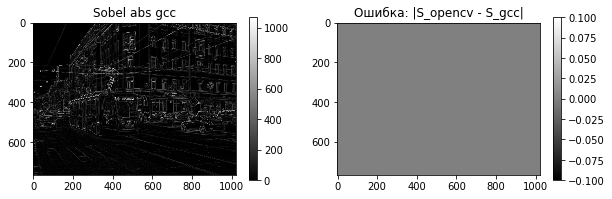

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
OpenCV image CRC: 0x33f27cb0
GCC image CRC   : 0x33f27cb0


In [30]:
print("Filtering time: 51.3 ms on Intel Core i5")

sobel_gcc = np.loadtxt("sobel_gcc_2.txt", dtype=np.int16, delimiter = "\t")

plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
plt.title("Sobel abs gcc")
plt.imshow(sobel_gcc[1:-1, 1:-1], cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Ошибка: |S_opencv - S_gcc|")
#plt.imshow(np.abs(sobel_opencv - sobel_gcc)[1:-1, 1:-1], cmap='gray')
plt.imshow(np.abs(sobel_opencv - sobel_gcc), cmap='gray')
plt.colorbar()
plt.show()

print(np.abs(sobel_opencv - sobel_gcc))


print("OpenCV image CRC:", hex(zlib.crc32(np.asarray(sobel_opencv, dtype="uint16").tobytes())))
print("GCC image CRC   :", hex(zlib.crc32(np.asarray(sobel_gcc, dtype="uint16").tobytes())))

### Одномерный массив

In [7]:
print("Filtering time: 50.3 ms on Intel Core i5")

sobel_gcc = np.loadtxt("sobel_a_gcc.txt", dtype=np.int16, delimiter = "\t")

plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
plt.title("Sobel abs gcc")
plt.imshow(sobel_gcc[1:-1, 1:-1], cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Ошибка: |S_opencv - S_gcc|")
plt.imshow(np.abs(sobel_opencv - sobel_gcc)[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

Filtering time: 50.3 ms on Intel Core i5


### Развёрнутые циклы

In [8]:
print("Filtering time: 15.04 ms on Intel Core i5")

sobel_gcc = np.loadtxt("sobel_nc_gcc.txt", dtype=np.int16, delimiter = "\t")

plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
plt.title("Sobel abs gcc")
plt.imshow(sobel_gcc[1:-1, 1:-1], cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Ошибка: |S_opencv - S_gcc|")
plt.imshow(np.abs(sobel_opencv - sobel_gcc)[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

Filtering time: 15.04 ms on Intel Core i5


### Кэширование

Filtering time: 9.25 ms on Intel Core i5
Filtering time with GCC -O2: 4.71 ms on Intel Core i5


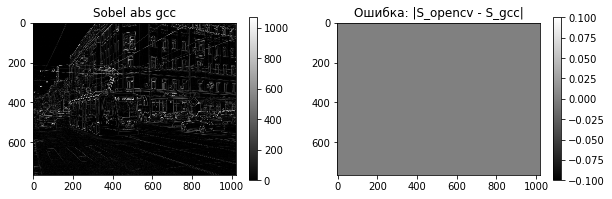

In [9]:
print("Filtering time: 9.25 ms on Intel Core i5")
print("Filtering time with GCC -O2: 4.71 ms on Intel Core i5")

sobel_gcc = np.loadtxt("sobel_c_gcc.txt", dtype=np.int16, delimiter = "\t")

plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
plt.title("Sobel abs gcc")
plt.imshow(sobel_gcc[1:-1, 1:-1], cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Ошибка: |S_opencv - S_gcc|")
plt.imshow(np.abs(sobel_opencv - sobel_gcc)[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

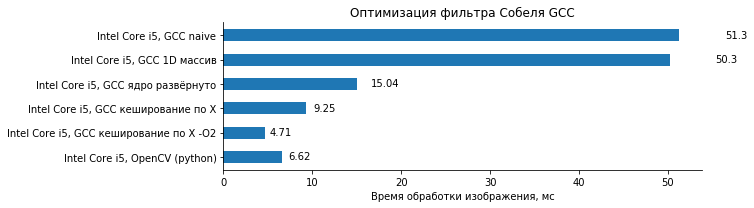

In [10]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
fig.set_size_inches(10, 3)

plt.title("Оптимизация фильтра Собеля GCC")

configurations = [    
    'Intel Core i5, OpenCV (python)',
    'Intel Core i5, GCC кеширование по X -O2',
    'Intel Core i5, GCC кеширование по X',
    'Intel Core i5, GCC ядро развёрнуто',
    'Intel Core i5, GCC 1D массив',
    'Intel Core i5, GCC naive'
]

proc_time_ms = [
    6.62,
    4.71,
    9.25,
    15.04,
    50.30,
    51.30,
]

y_pos = np.arange(len(configurations))
ax.barh(y_pos, proc_time_ms, height = 0.5, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(configurations)
for i, g in enumerate(proc_time_ms):
    ax.text(g * 1.1, i - 0.1, str(g))
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
#ax.set_xscale("log", nonposx='clip')

plt.xlabel("Время обработки изображения, мс")
i = 0
for spine in plt.gca().spines.values():
    if i == 1 or i == 3:
        spine.set_visible(False)
    i += 1
    
plt.tight_layout()
plt.savefig("gcc_opt.png", dpi = 300)
plt.show()

## OpenCL GPU

Filtering time: 2.56 ms on NVS 5400M
Filtering time: 1.78 ms on NVS 5400M с развёрнутым ядром Собеля
Filtering time: 1.41 ms on NVS 5400M без вычислений, только копирование


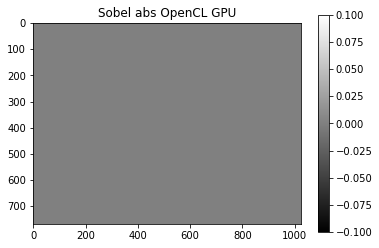

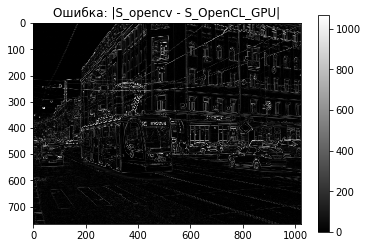

In [11]:
print("Filtering time: 2.56 ms on NVS 5400M")
print("Filtering time: 1.78 ms on NVS 5400M с развёрнутым ядром Собеля")
print("Filtering time: 1.41 ms on NVS 5400M без вычислений, только копирование")
sobel_opencl_gpu = np.loadtxt("sobel_gpu_opencl.txt", dtype=np.int16, delimiter = "\t")

plt.title("Sobel abs OpenCL GPU")
plt.imshow(sobel_opencl_gpu, cmap='gray')
plt.colorbar()
plt.show()

plt.title("Ошибка: |S_opencv - S_OpenCL_GPU|")
plt.imshow(np.abs(sobel_opencv - sobel_opencl_gpu)[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

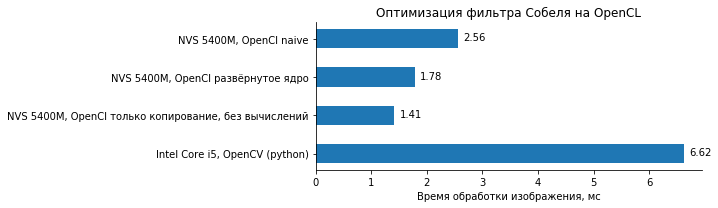

In [12]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
fig.set_size_inches(10, 3)

plt.title("Оптимизация фильтра Собеля на OpenCL")

configurations = [    
    'Intel Core i5, OpenCV (python)',
    'NVS 5400M, OpenCl только копирование, без вычислений',
    'NVS 5400M, OpenCl развёрнутое ядро',
    'NVS 5400M, OpenCl naive'
]

proc_time_ms = [
    6.62,
    1.41,
    1.78,
    2.56,
]

y_pos = np.arange(len(configurations))
ax.barh(y_pos, proc_time_ms, height = 0.5, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(configurations)
for i, g in enumerate(proc_time_ms):
    ax.text(g + 0.1, i - 0.05, str(g))
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
#ax.set_xscale("log", nonposx='clip')

plt.xlabel("Время обработки изображения, мс")
i = 0
for spine in plt.gca().spines.values():
    if i == 1 or i == 3:
        spine.set_visible(False)
    i += 1
    
plt.tight_layout()
plt.savefig("opencl_opt.png", dpi = 300)
plt.show()

## CUDA

Filtering time: 3.5 ms on NVS 5400M
Filtering time: 1.85 ms on NVS 5400M с развёрнутым ядром Собеля
Filtering time: 1.41 ms on NVS 5400M без вычислений, только копирование


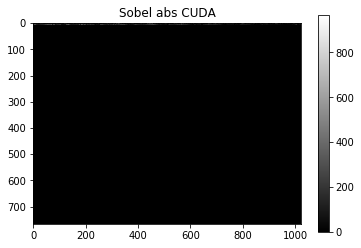

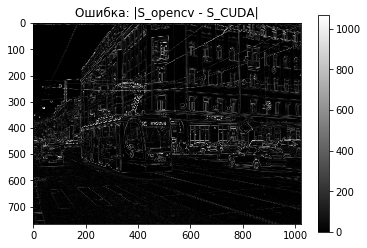

In [13]:
print("Filtering time: 3.5 ms on NVS 5400M")
print("Filtering time: 1.85 ms on NVS 5400M с развёрнутым ядром Собеля")
print("Filtering time: 1.41 ms on NVS 5400M без вычислений, только копирование")
sobel_cuda = np.loadtxt("sobel_cuda.txt", dtype=np.int16, delimiter = "\t")

plt.title("Sobel abs CUDA")
plt.imshow(sobel_cuda[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

plt.title("Ошибка: |S_opencv - S_CUDA|")
plt.imshow(np.abs(sobel_opencv - sobel_cuda)[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

## Parallella ARM GCC

Filtering time: 1062 ms Parallella ARM GCC


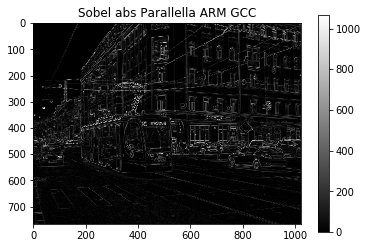

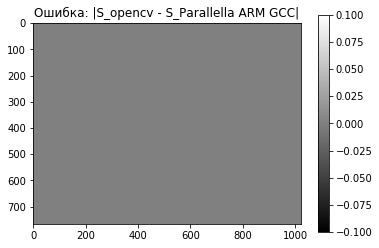

In [14]:
print("Filtering time: 1062 ms Parallella ARM GCC")
sobel_parallella_arm_gcc = np.loadtxt("sobel_parallella_arm_gcc.txt", dtype=np.int16, delimiter = "\t")

plt.title("Sobel abs Parallella ARM GCC")
plt.imshow(sobel_parallella_arm_gcc[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

plt.title("Ошибка: |S_opencv - S_Parallella ARM GCC|")
plt.imshow(np.abs(sobel_opencv - sobel_parallella_arm_gcc)[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

## Parallella Epiphany

Filtering time: 651.31 ms Epiphany


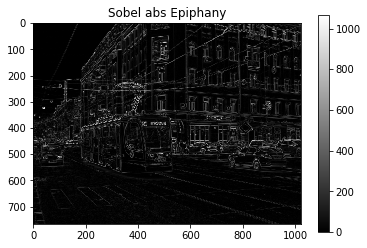

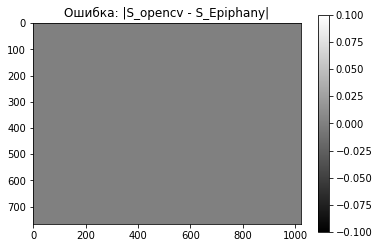

In [15]:
print("Filtering time: 651.31 ms Epiphany")
sobel_epiphany = np.loadtxt("sobel_epiphany.txt", dtype=np.int16, delimiter = "\t")

plt.title("Sobel abs Epiphany")
plt.imshow(sobel_epiphany[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

plt.title("Ошибка: |S_opencv - S_Epiphany|")
plt.imshow(np.abs(sobel_opencv - sobel_epiphany)[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

### MALT

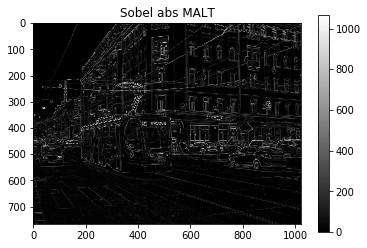

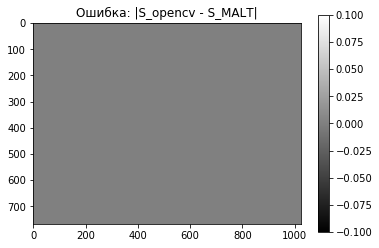

In [31]:
sobel_malt = np.loadtxt("sobel_malt.txt", dtype=np.int16, delimiter = "\t")

plt.title("Sobel abs MALT")
plt.imshow(sobel_malt[1:-1, 1:-1], cmap='gray')
plt.colorbar()
plt.show()

plt.title("Ошибка: |S_opencv - S_MALT|")
plt.imshow(np.abs(sobel_opencv - sobel_malt), cmap='gray')
plt.colorbar()
plt.show()

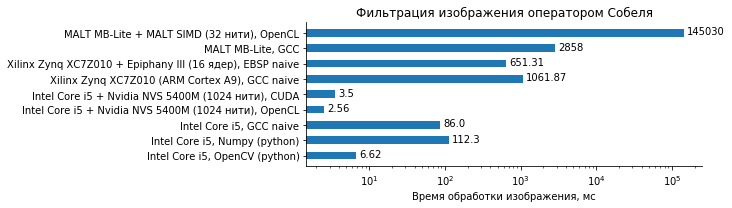

In [17]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
fig.set_size_inches(10, 3)

#plt.title("Фильтрация изображения 1024 x 768 пикселей оператором Собеля")
plt.title("Фильтрация изображения оператором Собеля")

configurations = [    
    'Intel Core i5, OpenCV (python)', 
    'Intel Core i5, Numpy (python)', 
    'Intel Core i5, GCC naive', 
    'Intel Core i5 + Nvidia NVS 5400M (1024 нити), OpenCL', 
    'Intel Core i5 + Nvidia NVS 5400M (1024 нити), CUDA',
    'Xilinx Zynq XC7Z010 (ARM Cortex A9), GCC naive',
    'Xilinx Zynq XC7Z010 + Epiphany III (16 ядер), EBSP naive', 
    'MALT MB-Lite, GCC',
    'MALT MB-Lite + MALT SIMD (32 нити), OpenCL',    
]

proc_time_ms = [
    6.62,
    112.30,
    86.00,
    2.56,
    3.5,
    1061.87,
    651.31,
    2858,
    145030
]

y_pos = np.arange(len(configurations))
ax.barh(y_pos, proc_time_ms, height = 0.5, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(configurations)
for i, g in enumerate(proc_time_ms):
    ax.text(g * 1.1, i - 0.1, str(g))
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
ax.set_xscale("log", nonposx='clip')

plt.xlabel("Время обработки изображения, мс")
i = 0
for spine in plt.gca().spines.values():
    if i == 1 or i == 3:
        spine.set_visible(False)
    i += 1
    
plt.tight_layout()
plt.savefig("timing.png", dpi = 300)
plt.show()

In [18]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
fig.set_size_inches(10, 4)

plt.title("Фильтрация изображения 1024 x 768 пикселей оператором Собеля")
#plt.title("Фильтрация изображения оператором Собеля")

plt.gca().invert_yaxis()

configurations = [    
    'Intel Core i5, OpenCV (python)', 
    'Intel Core i5, Numpy (python)', 
    'Intel Core i5, GCC', 
    'Intel Core i5 + Nvidia NVS 5400M (1024 нити), OpenCL', 
    'Intel Core i5 + Nvidia NVS 5400M (1024 нити), CUDA',
    'Xilinx Zynq XC7Z010 (ARM Cortex A9), GCC',
    'Xilinx Zynq XC7Z010 + Epiphany III (16 ядер), EBSP', 
    'MALT MB-Lite, GCC',
    'MALT MB-Lite + MALT SIMD (32 нити), OpenCL',    
]

proc_time_ms = [
    6.62,
    112.30,
    86.00,
    2.56,
    3.5,
    1061.87,
    651.31,
    2858,
    145030
]

y_pos = np.arange(len(configurations))
ax.barh(y_pos - 0.2, proc_time_ms, height = 0.5, align='center', label="Без оптимизации")
for i, g in enumerate(proc_time_ms):
    ax.text(g * 1.1, y_pos[i] - 0.1, str(g))

proc_time_ms_optimized = [
    1.78, # OpenCl
    4.71  # GCC
]
y_pos_optimized = np.array([3, 2.])

ax.barh(y_pos_optimized + 0.2, proc_time_ms_optimized, height = 0.5, align='center', label="После оптимизации")

for i, g in enumerate(proc_time_ms_optimized):
    ax.text(g * 1.1, y_pos_optimized[i] + 0.35, str(g))


ax.set_yticks(y_pos)
ax.set_yticklabels(configurations)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
ax.set_xscale("log", nonposx='clip')

plt.xlabel("Время обработки изображения, мс")
i = 0
for spine in plt.gca().spines.values():
    if i == 1 or i == 3:
        spine.set_visible(False)
    i += 1
    
    
plt.legend()
plt.tight_layout()
plt.savefig("timing.png", dpi = 300)
plt.show()

In [19]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
fig.set_size_inches(10, 4)

plt.title("Фильтрация изображения 1024 x 768 пикселей оператором Собеля")
#plt.title("Фильтрация изображения оператором Собеля")

plt.gca().invert_yaxis()

configurations = [    
    'Intel Core i5, OpenCV (python)', 
    'Intel Core i5, Numpy (python)', 
    'Intel Core i5, GCC', 
    'Intel Core i5 + Nvidia NVS 5400M (1024 нити), OpenCL', 
    'Intel Core i5 + Nvidia NVS 5400M (1024 нити), CUDA',
    'Xilinx Zynq XC7Z010 (ARM Cortex A9), GCC',
    'Xilinx Zynq XC7Z010 + Epiphany III (16 ядер), EBSP', 
    'MALT MB-Lite, GCC',
    'MALT MB-Lite + MALT SIMD (32 нити), OpenCL',    
]

proc_pwr_w = [
    35,#'Intel Core i5, OpenCV (python)', 
    35,#'Intel Core i5, Numpy (python)', 
    35,#'Intel Core i5, GCC', 
    55,#'Intel Core i5 + Nvidia NVS 5400M (1024 нити), OpenCL', 
    55,#'Intel Core i5 + Nvidia NVS 5400M (1024 нити), CUDA',
    3.3,#'Xilinx Zynq XC7Z010 (ARM Cortex A9), GCC',
    5,#'Xilinx Zynq XC7Z010 + Epiphany III (16 ядер), EBSP', 
    0.1,#'MALT MB-Lite, GCC',
    0.5,#'MALT MB-Lite + MALT SIMD (32 нити), OpenCL', 
]

proc_energy_mJ = np.array(proc_pwr_w) * np.array(proc_time_ms)

y_pos = np.arange(len(configurations))
ax.barh(y_pos - 0.2, proc_energy_mJ, height = 0.5, align='center', label="Без оптимизации")
for i, g in enumerate(proc_energy_mJ):
    ax.text(g * 1.1, y_pos[i] - 0.1, str(g))

proc_pwr_w_optimized = [
    55, # OpenCl
    35  # GCC
]

proc_energy_mJ_optimized = np.array(proc_pwr_w_optimized) * np.array(proc_time_ms_optimized)

y_pos_optimized = np.array([3, 2.])

ax.barh(y_pos_optimized + 0.2, proc_energy_mJ_optimized, height = 0.5, align='center', label="После оптимизации")

for i, g in enumerate(proc_energy_mJ_optimized):
    ax.text(g * 1.1, y_pos_optimized[i] + 0.35, str(g))


ax.set_yticks(y_pos)
ax.set_yticklabels(configurations)
    
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
ax.set_xscale("log", nonposx='clip')

plt.xlabel("Энергия, необходимая для расчёта, мДж")
i = 0
for spine in plt.gca().spines.values():
    if i == 1 or i == 3:
        spine.set_visible(False)
    i += 1
    
    
plt.legend()
plt.tight_layout()
plt.savefig("energy.png", dpi = 300)
plt.show()

## Посмотреть позже
- Retinex (оттакливаться от презентаций Singularis)

In [20]:
cv2.__version__

'3.4.1'